<a href="https://colab.research.google.com/github/kuds/rl-lunar-lander/blob/main/%5BLunar%20Lander%5D%20Proximal%20Policy%20Optimization%20(PPO).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proximal Policy Optimization (PPO)
---
In this notebook, you will implement a PPO agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [1]:
!pip install swig

In [2]:
!pip install stable_baselines3 gymnasium gymnasium[box2d]

In [3]:
import gymnasium
import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage
from stable_baselines3.common.vec_env import VecVideoRecorder

import torch
import numpy
import scipy
import platform
import IPython
import matplotlib
import matplotlib.pyplot

In [4]:
print("Python Version: {}".format(platform.python_version()))
print("Is Cuda Available: {}".format(torch.cuda.is_available()))
print("Torch Version: {}".format(torch.__version__))
print("Cuda Version: {}".format(torch.version.cuda))
print("Scipy Version: {}".format(scipy.__version__))
print("Numpy Version: {}".format(numpy.__version__))
print("Stable Baseline Version: {}".format(stable_baselines3.__version__))
print("IPython Version: {}".format(IPython.__version__))
print("Gymnasium Version: {}".format(gymnasium.__version__))

Python Version: 3.10.12
Is Cuda Available: True
Torch Version: 2.3.1+cu121
Cuda Version: 12.1
Scipy Version: 1.13.1
Numpy Version: 1.26.4
Stable Baseline Version: 2.3.2
IPython Version: 7.34.0
Gymnasium Version: 0.29.1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
env = gymnasium.make('LunarLander-v2')
print("Observation Space Size: ", env.observation_space.shape)
print("Action Space Size: ", env.action_space.shape)
env.close()

Observation Space Size:  (8,)
Action Space Size:  ()


In [6]:
#env = gymnasium.make("LunarLander-v2", continuous=True)
env = make_vec_env("LunarLander-v2", n_envs=1)

#env_val = gymnasium.make("LunarLander-v2", render_mode="rgb_array", continuous=True)
env_val = make_vec_env("LunarLander-v2", n_envs=1)

eval_callback = EvalCallback(env_val,
                             best_model_save_path="./logs/",
                             log_path="./logs/",
                             eval_freq=2000,
                             render=False,
                             deterministic=True,
                             n_eval_episodes=20)

# Initialize PPO
model = PPO('MlpPolicy', env, verbose=0, ent_coef=0.005)

# Train the model
model.learn(total_timesteps=4000,  progress_bar=True, callback=eval_callback)

# Save the model
model.save("ppo_lunar_lander")

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

Output()

Eval num_timesteps=2000, episode_reward=-274.59 +/- 137.15

Episode length: 71.95 +/- 11.86

New best mean reward!

Eval num_timesteps=4000, episode_reward=-515.57 +/- 165.43

Episode length: 157.35 +/- 49.16

Mean reward: -268.99 +/- 228.01


In [7]:
# Load the best model
env = make_vec_env("LunarLander-v2", n_envs=1, seed=0)
best_model_path = "./logs/best_model.zip"
best_model = PPO.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=20)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing Lunar Lander
env = VecVideoRecorder(env, "./videos/",
                       video_length=5000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix="best_model_lunar_lander_ppo")

obs = env.reset()
for _ in range(5000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
      break

env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best Model - Mean reward: -272.09 +/- 127.46
Moviepy - Building video /content/videos/best_model_lunar_lander_ppo-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/videos/best_model_lunar_lander_ppo-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/best_model_lunar_lander_ppo-step-0-to-step-5000.mp4


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


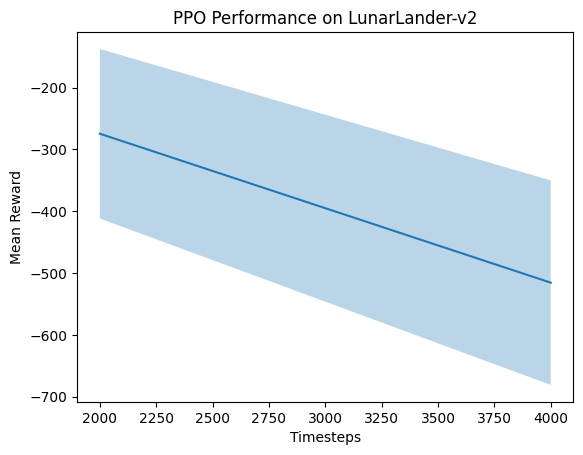

In [8]:
# Load the evaluations.npz file
data = numpy.load('./logs/evaluations.npz')

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps, mean_results - std_results, mean_results + std_results, alpha=0.3)
matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title('PPO Performance on LunarLander-v2')
matplotlib.pyplot.show()

In [9]:
env = gymnasium.make('LunarLanderContinuous-v2')
print("Observation Space Size: ", env.observation_space.shape)
print("Action Space Size: ", env.action_space.shape)
env.close()

Observation Space Size:  (8,)
Action Space Size:  (2,)


In [10]:
#env = gymnasium.make("LunarLander-v2", continuous=True)
env = make_vec_env("LunarLanderContinuous-v2", n_envs=1)

#env_val = gymnasium.make("LunarLander-v2", render_mode="rgb_array", continuous=True)
env_val = make_vec_env("LunarLanderContinuous-v2", n_envs=1)

eval_callback = EvalCallback(env_val,
                             best_model_save_path="./logs_con/",
                             log_path="./logs_con/",
                             eval_freq=2000,
                             render=False,
                             n_eval_episodes=20)

# Initialize PPO
model = PPO('MlpPolicy', env, verbose=0, ent_coef=0.005)

# Train the model
model.learn(total_timesteps=4000,  progress_bar=True, callback=eval_callback)

# Save the model
model.save("ppo_lunar_lander_continous")

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

Output()

Eval num_timesteps=2000, episode_reward=-270.40 +/- 112.58

Episode length: 128.15 +/- 39.66

New best mean reward!

Eval num_timesteps=4000, episode_reward=-104.11 +/- 68.44

Episode length: 70.25 +/- 10.36

New best mean reward!

Mean reward: -183.67 +/- 114.60


In [11]:
# Load the best model
env = make_vec_env("LunarLanderContinuous-v2", n_envs=1, seed=0)
best_model_path = "./logs_con/best_model.zip"
best_model = PPO.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=20)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing Lunar Lander
env = VecVideoRecorder(env, "./videos/",
                       video_length=5000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix="best_model_lunar_lander_ppo_con")

obs = env.reset()
for _ in range(5000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
      break

env.close()

Best Model - Mean reward: -87.04 +/- 51.91
Moviepy - Building video /content/videos/best_model_lunar_lander_ppo_con-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/videos/best_model_lunar_lander_ppo_con-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/best_model_lunar_lander_ppo_con-step-0-to-step-5000.mp4


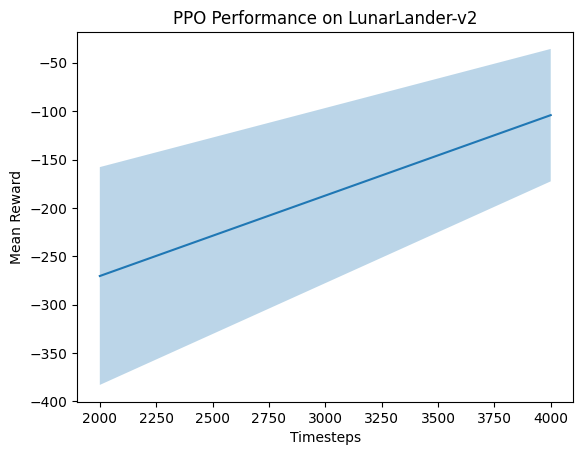

In [12]:
# Load the evaluations.npz file
data = numpy.load('./logs_con/evaluations.npz')

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps, mean_results - std_results, mean_results + std_results, alpha=0.3)
matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title('PPO Performance on LunarLander-v2')
matplotlib.pyplot.show()